<h1>Prueba de simulador</h1>
<p>Esta prueba consiste en usar el simulador para conocer los momentos en los que se obtendrían los pedidos por parte de Alemania, los momentos en los que se facturarían y el inventario proyectado en la bodeba de Alemania</p>

In [9]:
import pandas as pd
import numpy as np
from sim_utils.events import EventType, Event
from datetime import datetime
pd.options.display.max_columns = None

<h3>importar penplano</h3>

In [10]:
# importar penplano
penplano_path = 'V:\\2022\\PEND PLANO ENERO 3.xlsx'
pendiente_dtype = {'Cliente': object, 'Producto': object, 'Sc': object}
pendiente_colums = ['Pais', 'Mdo', 'Cliente', 'Desp.R.APS',
                    'Pendiente', 'Und', 'F.Ingreso', 'Producto', 'Stock']
pendiente_df = [
    pd.read_excel(penplano_path, sheet_name='PLANOCO', dtype=pendiente_dtype)[pendiente_colums],
    pd.read_excel(penplano_path, sheet_name='PLANOCR', dtype=pendiente_dtype)[pendiente_colums]]

# concatenar pendiente de ambas plantas
pendiente_df = pd.concat(pendiente_df)

# remover filas vacias
pendiente_df = pendiente_df[~pendiente_df['Pais'].isna()]

# Dejar columnas relevantes
pendiente_df = pendiente_df[pendiente_colums]
# Poner semana requerida
pendiente_df['SemanaRequerida'] = pendiente_df['Desp.R.APS'].dt.strftime("%Y%V").astype('int')
# dejar el pendiente organizado a la semana actual
pendiente_df['SemanaRequerida'] = pendiente_df['SemanaRequerida'].apply(lambda x: x if x >= 202152 else 202152)
# Sacar el pendiente para alemania
pendiente_df = pendiente_df[pendiente_df['Cliente']==100459].groupby(['Stock', 'SemanaRequerida'])[['Pendiente']].sum().reset_index()

In [11]:
semanas = sorted(list(pendiente_df['SemanaRequerida'].unique()))
semanas = {semanas[x]:x+10 for x in range(len(semanas))}
semanas

{202152: 10,
 202201: 11,
 202202: 12,
 202203: 13,
 202204: 14,
 202205: 15,
 202206: 16,
 202207: 17,
 202208: 18,
 202252: 19}

In [12]:
pendiente_df['Periodo'] = pendiente_df['SemanaRequerida'].map(semanas)

In [13]:
pendiente_df = pendiente_df.groupby(['Stock', 'Periodo'])[['Pendiente']].sum().reset_index()

<h3>Importar existencias y pendientes comerciales en bodega de Alemania</h3>

In [14]:
# importar existencias en bodega destino
existencias_gmb_path = 'D:\\OneDrive - Proquinal\\plan_abactecimiento\\suggested_program\\Germany Inventory Report 22.12.2021.xlsx'
existencias_gmb_df = pd.read_excel(existencias_gmb_path)
existencias_gmb_df = existencias_gmb_df.groupby(['Stock Code (CU)'])[['Total on stock', 'Commited/Sold']].sum().reset_index()
existencias_gmb_df['qty'] = existencias_gmb_df['Total on stock']-existencias_gmb_df['Commited/Sold']
existencias_gmb_df = existencias_gmb_df.groupby(['Stock Code (CU)'])['qty'].sum().reset_index().rename(columns={'Stock Code (CU)':'STOCK'})
existencias_gmb_df['Periodo'] = 0


<h3>Transitos actuales o arrivals</h3>

In [15]:
etapas_path = 'Y:\\LISTADOS\\1. Reportes_consolidados\\Reportes_20220103.xlsx'
etapas_df = pd.read_excel(etapas_path, sheet_name='Etapas')
etapas_df['CANTIDAD DESPACHADA'] = etapas_df['CANTIDAD DESPACHADA'].str.replace(',', '')
etapas_df['CANTIDAD DESPACHADA'] = etapas_df['CANTIDAD DESPACHADA'].astype('float')
etapas_df = etapas_df[etapas_df['COD_CLIENTE']==100459]
etapas_df['SemanaDespacho'] = pd.to_datetime(etapas_df['FECHA DE FACTURA'])
etapas_df['FechaArrivo'] =  etapas_df['SemanaDespacho'] +pd.DateOffset(days=35)
etapas_df['Periodo'] = etapas_df['FechaArrivo'].dt.strftime("%Y%V").astype('int')
etapas_df = etapas_df.groupby(['STOCK', 'Periodo'])[['CANTIDAD DESPACHADA']].sum().reset_index()

In [16]:
semanas = sorted(list(etapas_df['Periodo'].unique()))
semanas = {semanas[x]:x+2 for x in range(len(semanas))}
semanas

{202201: 2, 202202: 3, 202203: 4, 202204: 5}

In [17]:
etapas_df['Periodo'] = etapas_df['Periodo'].map(semanas)

In [18]:
# Unir pendientes y etapas en arrivos
arrivos_df = pd.concat([pendiente_df[['Stock', 'Periodo', 'Pendiente']].rename(columns={'Stock':'STOCK', 'Pendiente':'qty'}),
    etapas_df[['STOCK', 'CANTIDAD DESPACHADA', 'Periodo']].rename(columns={'CANTIDAD DESPACHADA':'qty'})]).groupby(['STOCK', 'Periodo'])[['qty']].sum().reset_index()

<h3>Forecast de venta</h3>

In [19]:
forecast_path = 'Y:\\PlaneacionDemanda\\Rollovers\\Legacy\\202112\\output\\Europa\\Europa_202112 Salida Numérica_BASE.txt'
forecast_df = pd.read_csv(forecast_path, sep='\t')
forecast_df = forecast_df[forecast_df['COD_EMPRESA']=='GMB'].copy()
#forecast_df = forecast_df[forecast_df['A�o']==2022].copy()
forecast_df['STOCK'] = forecast_df['PRODUCTO'].apply(lambda x: str(x).split(sep='=')[0])
forecast_df['FechaVenta'] = forecast_df.apply(lambda x: datetime(x['A�o'], x['Per�odo'],1), axis=1)
forecast_df['SemanaVenta'] = forecast_df['FechaVenta'].dt.strftime("%Y%V").astype('int')


In [20]:
semanas = sorted(list(forecast_df['SemanaVenta'].unique()))
semanas = {semanas[x]: int(str(semanas[x])[4:]) for x in range(len(semanas))}
semanas

{202148: 48,
 202205: 5,
 202209: 9,
 202213: 13,
 202217: 17,
 202222: 22,
 202226: 26,
 202231: 31,
 202235: 35,
 202239: 39,
 202244: 44,
 202248: 48,
 202252: 52,
 202305: 5,
 202309: 9,
 202313: 13,
 202318: 18,
 202322: 22,
 202326: 26,
 202331: 31,
 202335: 35,
 202339: 39,
 202344: 44,
 202352: 52}

In [21]:
forecast_df['Periodo'] = forecast_df['SemanaVenta'].map(semanas)

In [22]:
forecast_df = forecast_df.groupby(['STOCK', 'Periodo'])[['Pron�stico']].sum().reset_index().rename(columns={'Pron�stico':'qty'})

In [23]:
forecast_df['TipoDato'] = 'Forecast'
arrivos_df['TipoDato'] = 'Arrivals'
existencias_gmb_df['TipoDato'] = 'IOH_Inicial'

In [24]:
data_df = pd.concat([forecast_df, arrivos_df, existencias_gmb_df]).pivot_table(index=['STOCK', 'TipoDato'], columns='Periodo', values='qty', aggfunc=np.sum).fillna(0.0)

In [25]:
data_df.loc[('105-8028','Forecast')].reset_index()

,Periodo,105-8028
,,Forecast
0,0,0.00
1,2,0.00
2,3,0.00
3,4,0.00
4,5,757.04
5,9,723.17
6,10,0.00
7,11,0.00
8,12,0.00


<h3>Usar simulador</h3>

In [73]:

from sim_utils.events import Event, EventType
from sim_utils.simulators import ReviewPeriodicSimpleSimulator


In [74]:
clock = list(data_df.loc[('105-8028','Forecast')].index)
forecast = list(data_df.loc[('105-8028','Forecast')])
arrivals = list(data_df.loc[('105-8028','Arrivals')])
initial_ioh = data_df.loc[('105-8028','IOH_Inicial')][0]
week_average_demand = sum(forecast)/52
week_stdevit_demand = np.std(forecast + [0 for i in range(52 - len(forecast))])
review_period = 2
kCSL = 1.64
lt = 12
D_Lt_R = week_average_demand * (review_period + lt)
S_Lt_R = ((week_stdevit_demand**2) * (review_period + lt))**0.5
ss = kCSL* S_Lt_R
oul = D_Lt_R + ss


In [75]:
sim = ReviewPeriodicSimpleSimulator(initial_inventory=initial_ioh, lead_time=12, order_up_to_level=oul, review_period=review_period)

for i in range(len(forecast)):
    if forecast[i]>0:
        sim.event_queue.add_event(Event(clock=clock[i], type_of_event=EventType.DEMAND, event_name=f'Forecast {i}', document={'qty':forecast[i]}))
    if arrivals[i]>0:
        sim.event_queue.add_event(Event(clock=clock[i], type_of_event=EventType.ARRIVAL, event_name=f'Scheduled arrival {i}', document={'qty':arrivals[i]}))
        sim.quantity_ordered += arrivals[i]

for i in range(110):
    sim.advance_time()


	Review Period
	ordenando 2286.4239878248445
1 : Inventario on hand: 0 Backorder: -260.0 ordered: 4270.4239878248445 inventory_position 4010.4239878248445
2 : Inventario on hand: 0 Backorder: -260.0 ordered: 4270.4239878248445 inventory_position 4010.4239878248445
	Llegada por 1984.0
	Review Period
3 : Inventario on hand: 1724.0 Backorder: 0 ordered: 2286.4239878248445 inventory_position 4010.4239878248445
4 : Inventario on hand: 1724.0 Backorder: 0 ordered: 2286.4239878248445 inventory_position 4010.4239878248445
	Review Period
5 : Inventario on hand: 1724.0 Backorder: 0 ordered: 2286.4239878248445 inventory_position 4010.4239878248445
	atendiendo venta por 757.04 con inventario de 1724.0
6 : Inventario on hand: 966.96 Backorder: 0 ordered: 2286.4239878248445 inventory_position 3253.3839878248446
	Review Period
	ordenando 757.04
7 : Inventario on hand: 966.96 Backorder: 0 ordered: 3043.4639878248445 inventory_position 4010.4239878248445
8 : Inventario on hand: 966.96 Backorder: 0 orde

In [70]:
stats = sim.statistics_dataframe

In [45]:
import matplotlib.pyplot as plt

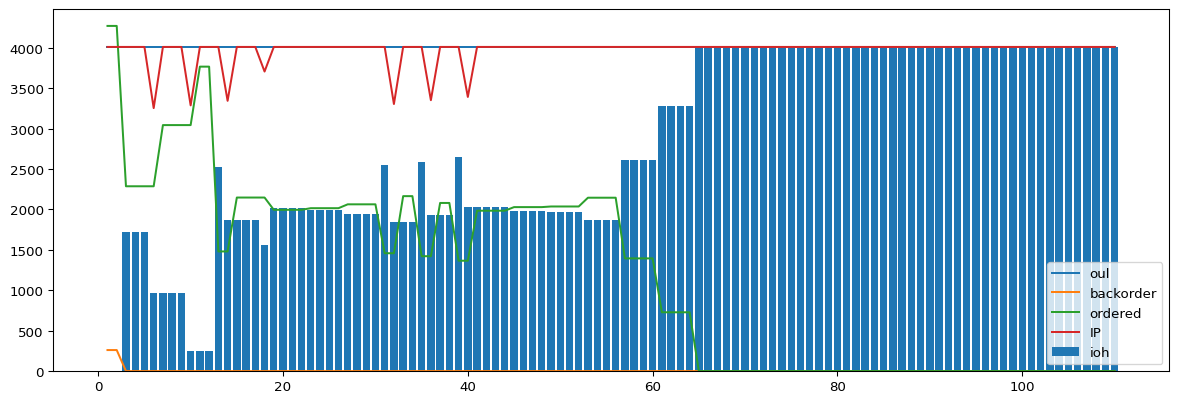

In [72]:
x = stats['clock']
plt.figure(dpi=96, figsize=(15,5))
plt.plot(x,stats['oul'], label='oul')
plt.bar(x, stats['Inventory_on_hand'], label='ioh')
plt.plot(x, stats['backorder'], label='backorder')
plt.plot(x, stats['Quantity_ordered'], label='ordered')
plt.plot(x, stats['inventory_position'], label='IP')
plt.legend()
plt.show()